# Supervised HMM segmentation

## Init

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, accuracy_score
import datetime as dt
from scipy import signal
import os
from pathlib import Path
from pprint import pprint

In [2]:
from segmentation_utils import (
    extract_eef_data_from_rosbag,
    get_ground_truth_segmentation,
    get_bagfiles_from_json,
)

In [3]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS
from pyro.ops.indexing import Vindex

In [4]:
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

## Data files

In [5]:
# data_path_root = Path("../table-task-ur5e")
data_path_root = Path(".")
data_path_root.exists()

True

In [6]:
ground_truth_segm_file = data_path_root / "table_task_UR5e_ground_truth.json"
ground_truth_segm_file.exists()

True

In [7]:
bagfiles = get_bagfiles_from_json(ground_truth_segm_file=ground_truth_segm_file)
bagfiles

[PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [8]:
filenum = 0
bagfile = bagfiles[filenum]
bagfile

PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag')

## Preprocessing

In [9]:
traj = extract_eef_data_from_rosbag(bagfile)
traj

Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag`


  0%|          | 0/186839 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


,x,y,z,timestamp,gripper
0,-0.078980,-0.323035,0.395559,2025-09-08 15:33:23.375930098-05:00,0.01
1,-0.079005,-0.323048,0.395506,2025-09-08 15:33:23.378239546-05:00,0.01
2,-0.078984,-0.323033,0.395563,2025-09-08 15:33:23.380529991-05:00,0.01
3,-0.078981,-0.323044,0.395566,2025-09-08 15:33:23.382326749-05:00,0.01
4,-0.078974,-0.323039,0.395514,2025-09-08 15:33:23.384065170-05:00,0.01
...,...,...,...,...,...
58998,0.261748,-0.304659,0.163334,2025-09-08 15:35:21.436463404-05:00,0.01
58999,0.261760,-0.304677,0.163333,2025-09-08 15:35:21.438276950-05:00,0.01
59000,0.261759,-0.304681,0.163327,2025-09-08 15:35:21.440569373-05:00,0.01
59001,0.261747,-0.304674,0.163330,2025-09-08 15:35:21.442307159-05:00,0.01


In [10]:
# df = traj.diff().mean().timestamp.total_seconds()
# df

In [11]:
# downsampling = 10

In [12]:
# freq = 1 / (df * downsampling)
# freq

In [13]:
# threshold = 0.6
# traj.loc[traj.gripper < threshold, "gripper"] = 0
# traj.loc[traj.gripper >= threshold, "gripper"] = 1

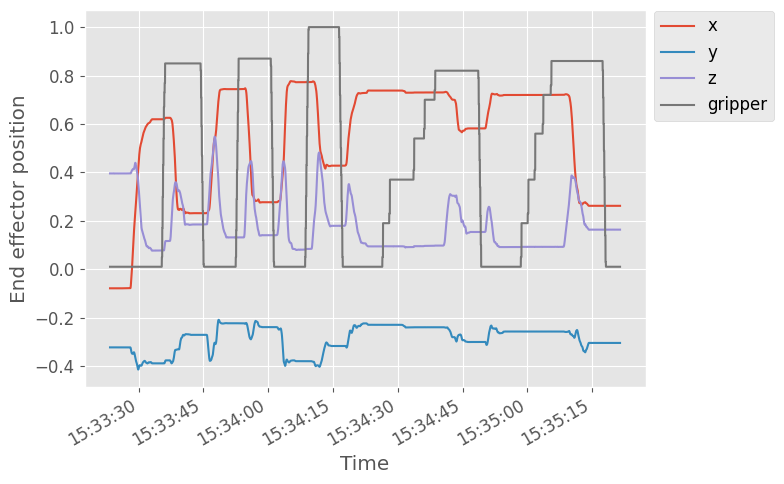

In [14]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(8, 5))
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamp, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamp, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamp, traj.z, label="z")  # , color=cmap[2])
    ax.plot(traj.timestamp, traj.gripper, label="gripper")  # , color=cmap[3])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    # ax.legend(loc="best")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

## Ground truth segmentation

In [15]:
gt_segm_dict = get_ground_truth_segmentation(
    ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
)
pprint(gt_segm_dict)

{'HigherLevel': {'cup': {'end': 1757363639, 'ini': 1757363626},
                 'fork': {'end': 1757363687, 'ini': 1757363658},
                 'napkin': {'end': 1757363655, 'ini': 1757363642},
                 'plate': {'end': 1757363623, 'ini': 1757363608},
                 'spoon': {'end': 1757363716, 'ini': 1757363690}},
 'LowerLevel': {'grasping': [{'end': 1757363617, 'ini': 1757363614},
                             {'end': 1757363634, 'ini': 1757363631},
                             {'end': 1757363650, 'ini': 1757363647},
                             {'end': 1757363681, 'ini': 1757363665},
                             {'end': 1757363708, 'ini': 1757363696}],
                'placing': [{'end': 1757363623, 'ini': 1757363617},
                            {'end': 1757363639, 'ini': 1757363634},
                            {'end': 1757363655, 'ini': 1757363650},
                            {'end': 1757363687, 'ini': 1757363681},
                            {'end': 1757363716, 'ini'

In [79]:
# def simplify2pickNplace(gt_segm_dict):
#     for mvt in gt_segm_dict["LowerLevel"].keys():
#         if mvt == "reaching":
#             for idx, val in enumerate(gt_segm_dict["LowerLevel"][mvt]):
#                 val["end"] = gt_segm_dict["LowerLevel"]["grasping"][idx]["end"]
#         elif mvt == "placing":
#             for idx, val in enumerate(gt_segm_dict["LowerLevel"][mvt]):
#                 val["end"] = gt_segm_dict["LowerLevel"]["releasing"][idx]["end"]

#     del gt_segm_dict["LowerLevel"]["grasping"]
#     del gt_segm_dict["LowerLevel"]["releasing"]
#     return gt_segm_dict

# gt_segm_dict = simplify2pickNplace(gt_segm_dict=gt_segm_dict)
# pprint(gt_segm_dict)

In [80]:
# def filter_fork_spoon(gt_segm_dict, traj):
#     ts_cut = np.min(
#         [
#             gt_segm_dict["HigherLevel"]["spoon"]["ini"],
#             gt_segm_dict["HigherLevel"]["fork"]["ini"],
#         ]
#     )
#     traj = traj[
#         traj.timestamp
#         < pd.Timestamp(
#             dt.datetime.fromtimestamp(ts_cut) - dt.timedelta(hours=1),
#             tz="EST",
#         )
#     ]
#     del gt_segm_dict["HigherLevel"]["fork"]
#     del gt_segm_dict["HigherLevel"]["spoon"]
#     for key in gt_segm_dict["LowerLevel"].keys():
#         del gt_segm_dict["LowerLevel"][key][-2:]
#     return traj, gt_segm_dict

# # traj, gt_segm_dict = filter_fork_spoon(gt_segm_dict=gt_segm_dict, traj=traj)
# # pprint(gt_segm_dict)
# # traj.shape

### Higher level movements

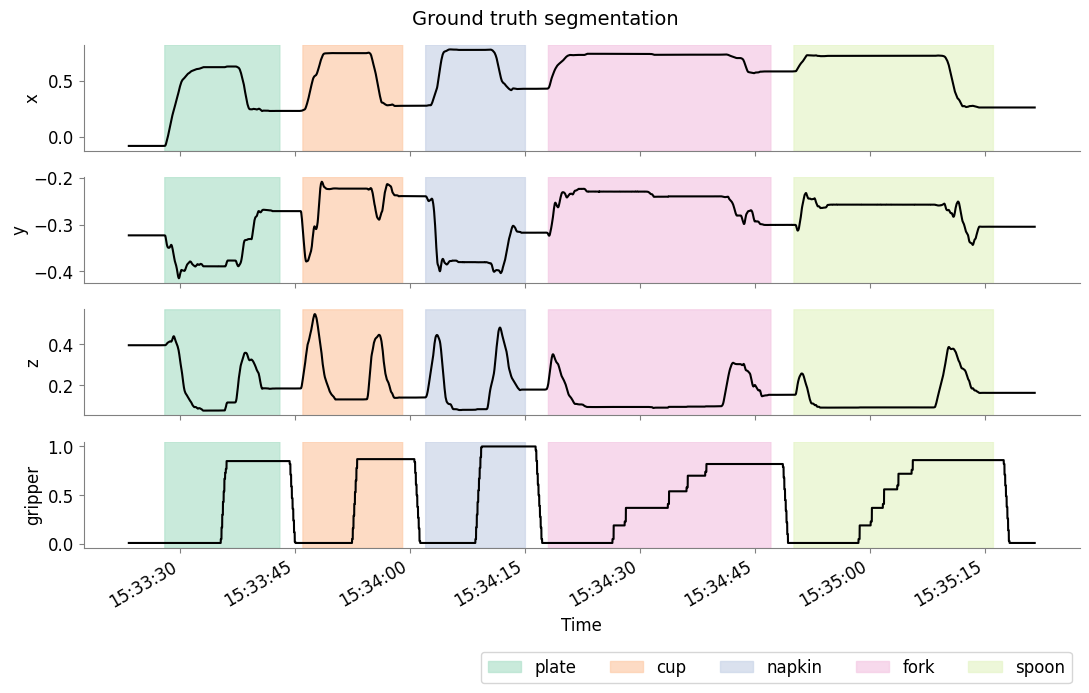

In [18]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    y_range = np.abs(y_high - y_low) / 2
    y_top = y_high + 0.1 * y_range
    y_bottom = y_low - 0.1 * y_range
    ax.set_ylim(bottom=y_bottom, top=y_top)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
        sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
        xs = traj.timestamp[
            (
                traj.timestamp
                > pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["ini"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
            & (
                traj.timestamp
                < pd.Timestamp(
                    dt.datetime.fromtimestamp(sect_dict_current["end"])
                    - dt.timedelta(hours=1),
                    tz="EST",
                )
            )
        ]  # - dt.timedelta(hours=5)
        ax.fill_between(
            x=xs,
            y1=y_bottom,
            y2=y_top,
            color=cmap[sect_i],
            alpha=0.7,
            # transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
axes[-1].legend(
    # bbox_to_anchor=(0.75, -0.7), ncol=len(gt_segm_dict["HigherLevel"].keys())
    bbox_to_anchor=(1, -0.9),
    ncol=len(gt_segm_dict["HigherLevel"].keys()),
    fontsize=12,
)
fig.suptitle("Ground truth segmentation", fontsize=14)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Lower level movements

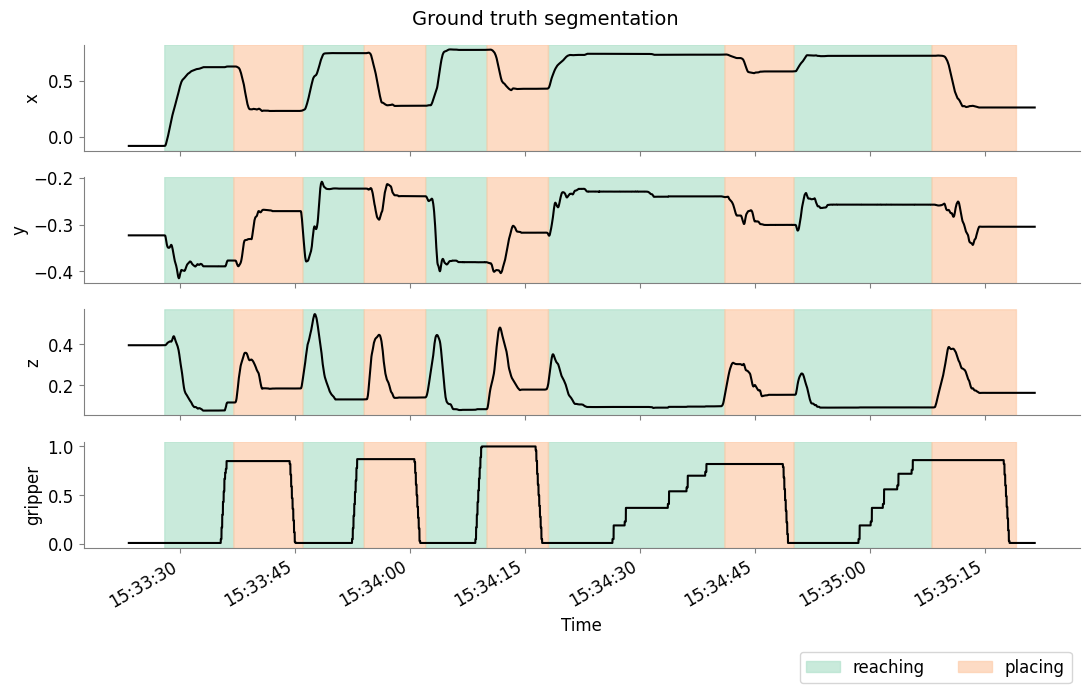

In [19]:
df_labels = list(traj.drop(columns=["timestamp"]).keys())
fig, axes = plt.subplots(
    nrows=len(df_labels), ncols=1, sharex=True, sharey=False, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(traj.timestamp, traj[df_labels[idx]], "k")
    ax.set_ylabel(df_labels[idx])
    ax.spines[["right", "top"]].set_visible(False)

    y_low = traj[df_labels[idx]].min()
    y_high = traj[df_labels[idx]].max()
    y_range = np.abs(y_high - y_low) / 2
    y_top = y_high + 0.1 * y_range
    y_bottom = y_low - 0.1 * y_range
    ax.set_ylim(bottom=y_bottom, top=y_top)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    for sect_i, sect_key in enumerate(gt_segm_dict["LowerLevel"].keys()):
        skill_current = gt_segm_dict["LowerLevel"][sect_key]
        for skill_i, skill_val in enumerate(skill_current):
            xs = traj.timestamp[
                (
                    traj.timestamp
                    > pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["ini"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
                & (
                    traj.timestamp
                    < pd.Timestamp(
                        dt.datetime.fromtimestamp(skill_val["end"])
                        - dt.timedelta(hours=1),
                        tz="EST",
                    )
                )
            ]  # - dt.timedelta(hours=5)
            if skill_i == 0:
                ax.fill_between(
                    x=xs,
                    y1=y_bottom,
                    y2=y_top,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                    label=sect_key,
                )
            else:
                ax.fill_between(
                    x=xs,
                    y1=y_bottom,
                    y2=y_top,
                    color=cmap[sect_i],
                    alpha=0.7,
                    # transform=ax.get_xaxis_transform(),
                )

axes[-1].set_xlabel("Time")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
# axes[-1].legend(
#     bbox_to_anchor=(0.62, -0.7), ncol=len(gt_segm_dict["LowerLevel"].keys())
# )
axes[-1].legend(
    bbox_to_anchor=(1, -0.9), ncol=len(gt_segm_dict["LowerLevel"].keys()), fontsize=12
)
fig.suptitle("Ground truth segmentation", fontsize=14)
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

## Segmentation

### Hyperparameters

In [20]:
# downsampling_factor = 200
resample_num = 2**8
# resample_num = 2**7
print(f"Resampling to {resample_num} data points")

Resampling to 256 data points


In [21]:
# what_segments = "HigherLevel"
what_segments = "LowerLevel"

labels = gt_segm_dict[what_segments].keys()
labels

dict_keys(['reaching', 'placing'])

In [22]:
# num_samples = 2**7
# warmup_steps = 2**6
num_samples = 150
warmup_steps = round(num_samples / 3)
print(f"Number of samples: {num_samples}")
print(f"Number of warmup steps: {warmup_steps}")

Number of samples: 150
Number of warmup steps: 50


### Preprocessing

In [23]:
# true_cps = np.ones((len(gt_segm_dict["HigherLevel"]) - 1)) * np.nan
# for sect_i, sect_key in enumerate(gt_segm_dict["HigherLevel"].keys()):
#     sect_dict_current = gt_segm_dict["HigherLevel"][sect_key]
#     if sect_i < len(true_cps):
#         true_cps[sect_i] = sect_dict_current["end"]
# true_cps

In [24]:
X = traj.drop(columns=["timestamp"])
X

,x,y,z,gripper
0,-0.078980,-0.323035,0.395559,0.01
1,-0.079005,-0.323048,0.395506,0.01
2,-0.078984,-0.323033,0.395563,0.01
3,-0.078981,-0.323044,0.395566,0.01
4,-0.078974,-0.323039,0.395514,0.01
...,...,...,...,...
58998,0.261748,-0.304659,0.163334,0.01
58999,0.261760,-0.304677,0.163333,0.01
59000,0.261759,-0.304681,0.163327,0.01
59001,0.261747,-0.304674,0.163330,0.01


In [25]:
def get_closest_ts(traj_ts, query_idx):
    idx2ts = pd.Timestamp(
        dt.datetime.fromtimestamp(query_idx) - dt.timedelta(hours=1),
        tz="EST",
    )
    closest_idx = (traj_ts - idx2ts).abs().argmin()
    return closest_idx

In [26]:
def create_supervised_labels(what_segments, gt_segm_dict, traj):
    y = np.ones(shape=traj.shape[0]) * np.nan
    if what_segments == "HigherLevel":
        for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
            sect_dict_current = gt_segm_dict[what_segments][sect_key]
            idx_ini = get_closest_ts(
                traj_ts=traj.timestamp, query_idx=sect_dict_current["ini"]
            )
            idx_end = get_closest_ts(
                traj_ts=traj.timestamp, query_idx=sect_dict_current["end"]
            )
            if idx_ini == idx_end:
                warnings.warn(
                    "The start and end indexes of the section are the same at:\n"
                    f"`{what_segments}` segmentation, `{sect_key}` section"
                )
            y[idx_ini:idx_end] = sect_i

    elif what_segments == "LowerLevel":
        for sect_i, sect_key in enumerate(gt_segm_dict[what_segments].keys()):
            skill_current = gt_segm_dict[what_segments][sect_key]
            for skill_i, skill_val in enumerate(skill_current):
                idx_ini = get_closest_ts(
                    traj_ts=traj.timestamp, query_idx=skill_val["ini"]
                )
                idx_end = get_closest_ts(
                    traj_ts=traj.timestamp, query_idx=skill_val["end"]
                )
                if idx_ini == idx_end:
                    warnings.warn(
                        "The start and end indexes of the section are the same at:\n"
                        f"`{what_segments}` segmentation, `{sect_key}` section, skill index: {skill_i}"
                    )
                y[idx_ini:idx_end] = sect_i

    else:
        raise ValueError("what_segments can only be 'HigherLevel' or 'LowerLevel'")

    return y

In [27]:
y = create_supervised_labels(
    what_segments=what_segments, gt_segm_dict=gt_segm_dict, traj=traj
)
y

array([nan, nan, nan, ..., nan, nan, nan], shape=(59003,))

In [28]:
np.unique(y)

array([ 0.,  1., nan])

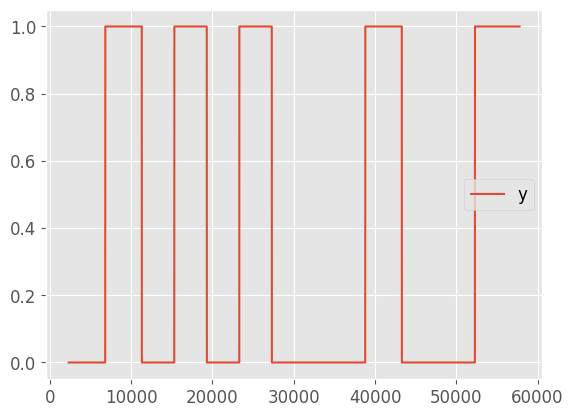

In [29]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y, label="y")
    ax.legend(loc="best")
    plt.show()

In [30]:
idx2filter = np.where(~np.isnan(y))
idx2filter

(array([ 2310,  2311,  2312, ..., 57778, 57779, 57780], shape=(55471,)),)

In [31]:
y_filtered = y[idx2filter]
y_filtered

array([0., 0., 0., ..., 1., 1., 1.], shape=(55471,))

In [32]:
np.unique(y_filtered)

array([0., 1.])

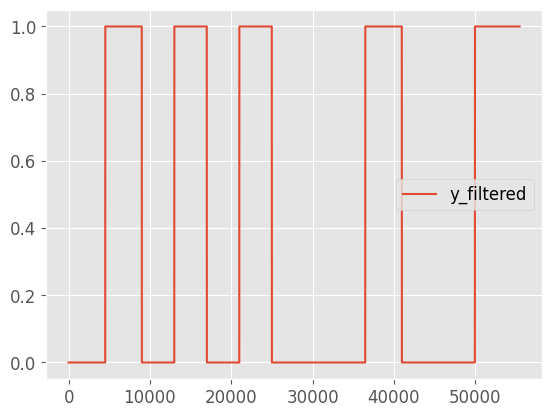

In [33]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_filtered, label="y_filtered")
    ax.legend(loc="best")
    plt.show()

In [34]:
X_filtered = X.iloc[idx2filter]
X_filtered

,x,y,z,gripper
2310,-0.078926,-0.323060,0.395548,0.01
2311,-0.078946,-0.323059,0.395536,0.01
2312,-0.078940,-0.323058,0.395538,0.01
2313,-0.078948,-0.323073,0.395527,0.01
2314,-0.078929,-0.323069,0.395526,0.01
...,...,...,...,...
57776,0.261758,-0.304680,0.163331,0.01
57777,0.261742,-0.304691,0.163333,0.01
57778,0.261758,-0.304664,0.163325,0.01
57779,0.261772,-0.304679,0.163344,0.01


In [35]:
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_filtered)
X_scaled

array([[2.56708209e-05, 4.44542207e-01, 6.77456031e-01, 0.00000000e+00],
       [2.00187647e-06, 4.44546057e-01, 6.77430171e-01, 0.00000000e+00],
       [8.44414749e-06, 4.44553037e-01, 6.77433296e-01, 0.00000000e+00],
       ...,
       [3.98117123e-01, 5.33982905e-01, 1.84106796e-01, 0.00000000e+00],
       [3.98133455e-01, 5.33914008e-01, 1.84147003e-01, 0.00000000e+00],
       [3.98104229e-01, 5.33973007e-01, 1.84123757e-01, 0.00000000e+00]],
      shape=(55471, 4))

In [36]:
# X_down = signal.decimate(x=X_filtered, q=downsampling_factor, axis=0)
X_down = signal.resample(x=X_filtered, num=resample_num, axis=0)
X_down.shape

(256, 4)

In [37]:
minmaxscaler = MinMaxScaler(feature_range=(0, 1))
X_down_scaled = minmaxscaler.fit_transform(X_down)
X_down_scaled.shape

(256, 4)

In [38]:
np.any(np.isinf(X_down_scaled)), np.any(np.isnan(X_down_scaled))

(np.False_, np.False_)

In [39]:
# y_down = np.round(signal.decimate(x=y_filtered, q=downsampling_factor, axis=0)).astype(
#     int
# )
y_down = np.round(signal.resample(x=y_filtered, num=resample_num, axis=0)).astype(int)
y_down

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
np.unique(y_down)

array([0, 1])

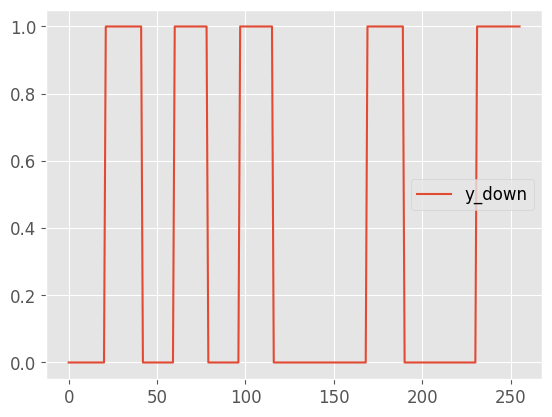

In [41]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_down, label="y_down")
    ax.legend(loc="best")
    plt.show()

In [42]:
# timestamp_down = traj.timestamp[
#     np.arange(start=traj.index.start, stop=traj.index.stop, step=downsampling_factor)
# ]
# timestamp_down

### Supervised HMM

In [43]:
supervised_classes = torch.tensor(y_down, dtype=int)
supervised_observations = torch.tensor(X_down_scaled)

In [44]:
supervised_classes.shape, supervised_observations.shape

(torch.Size([256]), torch.Size([256, 4]))

In [45]:
supervised_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [46]:
# pyro.set_rng_seed(1)

num_hidden_states = len(labels)  # number of hidden states
num_features = X.shape[1]  # number of continuous features

# Priors for transition probabilities
transition_prior = torch.empty(num_hidden_states).fill_(1.0)

# Sample transition probabilities
transition_prob = dist.Dirichlet(transition_prior).sample(
    torch.Size([num_hidden_states])
)

In [47]:
def equilibrium(mc_matrix):
    """
    Calculate the equilibrium distribution of a Markov chain.
    Returns a 1D tensor of probabilities.
    """
    n = mc_matrix.size(0)
    # Create a system of linear equations
    A = torch.eye(n, dtype=float) - mc_matrix.t() + 1
    b = torch.ones(n, dtype=float)
    # Solve for equilibrium distribution
    equilibrium_dist = torch.linalg.solve(A, b)
    # Normalize to ensure it's a valid probability distribution
    equilibrium_dist = equilibrium_dist / equilibrium_dist.sum()
    return equilibrium_dist

In [48]:
start_prob = equilibrium(transition_prob)
start_prob

tensor([0.3010, 0.6990], dtype=torch.float64)

In [49]:
# def supervised_hmm_continuous(classes, observations, num_hidden_states, num_features):
#     num_timesteps = len(observations)

#     with pyro.plate("prob_plate", num_hidden_states):
#         transition_prob = pyro.sample(
#             "transition_prob", dist.Dirichlet(transition_prior)
#         )

#         # # Sample emission parameters for each state
#         # emission_locs = pyro.sample(
#         #     "emission_locs",
#         #     dist.Normal(0, 5).expand([num_hidden_states, num_features]).to_event(2),
#         # )
#         emission_locs = pyro.sample(
#             "emission_locs", dist.Normal(0, 3).expand([num_features]).to_event(1)
#         )

#         # # Use diagonal covariance for simplicity
#         # emission_scales = pyro.sample(
#         #     "emission_scales",
#         #     dist.LogNormal(0, 1).expand([num_hidden_states, num_features]).to_event(2),
#         # )
#         emission_scales = pyro.sample(
#             "emission_scales", dist.LogNormal(0, 1).expand([num_features]).to_event(1)
#         )

#     class_id = classes[0]
#     for t in range(num_timesteps):
#         if t > 0:
#             class_id = pyro.sample(
#                 f"class_id_{t}",
#                 dist.Categorical(transition_prob[class_id]),
#                 obs=classes[t],
#             )

#         # Emit continuous observation
#         pyro.sample(
#             f"obs_{t}",
#             dist.Normal(emission_locs[class_id], emission_scales[class_id]).to_event(1),
#             obs=observations[t],
#         )

In [50]:
def supervised_hmm_vectorized(classes, observations, num_hidden_states, num_features):
    """
    A fully vectorized supervised HMM.

    Args:
        classes: LongTensor of shape (Batch, Time)
        observations: Tensor of shape (Batch, Time, Features)
        num_hidden_states: int
        num_features: int
    """

    # Preprocessing to handle non-batched input (Time, ...)
    if len(classes.shape) < 2:
        classes = classes.unsqueeze(dim=0)
    if len(observations.shape) < 3:
        observations = observations.unsqueeze(dim=0)

    # 1. Global Parameters
    # --------------------
    # These are sampled once and shared across all data.
    # The redundant 'prob_plate' is removed as the shapes are defined explicitly.

    # Transition Probabilities (H x H Matrix)
    # The inner torch.ones(H, H) creates H Dirichlet distributions (one for each row/outgoing state).
    # .to_event(1) correctly marks the last dimension (H) as the event dimension (a probability vector).
    transition_prob = pyro.sample(
        "transition_prob",
        dist.Dirichlet(torch.ones(num_hidden_states, num_hidden_states)).to_event(1),
    )

    # Emission Locations (H x F Matrix)
    # H independent normal distributions, each giving F features.
    emission_locs = pyro.sample(
        "emission_locs",
        dist.Normal(0, 3).expand([num_hidden_states, num_features]).to_event(1),
    )

    # Emission Scales (H x F Matrix)
    emission_scales = pyro.sample(
        "emission_scales",
        dist.LogNormal(0, 1).expand([num_hidden_states, num_features]).to_event(1),
    )

    # 2. Vectorized Transitions
    # -------------------------
    # Logic: We model P(y_t | y_{t-1}).
    # We take the slices 0..T-1 (prev) and 1..T (curr) and flatten them.

    # Slice to get previous and current states
    # shape: (Batch, Time-1)
    y_prev = classes[:, :-1]
    y_curr = classes[:, 1:]

    # Flatten to (Batch * (Time-1))
    y_prev_flat = y_prev.reshape(-1)
    y_curr_flat = y_curr.reshape(-1)

    with pyro.plate("transition_data", len(y_prev_flat)):
        # Vindex allows us to select the row corresponding to the previous state
        # for every single transition in the dataset simultaneously.
        trans_probs = Vindex(transition_prob)[y_prev_flat]

        pyro.sample("class_transitions", dist.Categorical(trans_probs), obs=y_curr_flat)

    # 3. Vectorized Emissions
    # -----------------------
    # Logic: We model P(x_t | y_t).
    # Since we know y_t, every emission is independent given the parameters.
    # We flatten (Batch, Time) into (Batch * Time).

    # Flatten classes to (Batch * Time)
    y_flat = classes.reshape(-1)

    # Flatten observations to (Batch * Time, Features)
    obs_flat = observations.reshape(-1, num_features)

    with pyro.plate("emission_data", len(y_flat)):
        # Pick the mu and sigma for every single timestep in the entire batch
        # dimensions: Vindex(H, F)[(B*T)] -> (B*T, F)
        locs = Vindex(emission_locs)[y_flat]
        scales = Vindex(emission_scales)[y_flat]

        pyro.sample("obs_all", dist.Normal(locs, scales).to_event(1), obs=obs_flat)

In [51]:
# def supervised_gmm_hmm(classes, observations, num_mixture_components):
#     num_timesteps = len(observations)

#     # Ensure observations are the right type
#     observations = observations.float()

#     with pyro.plate("states", num_hidden_states):
#         transition_prob = pyro.sample(
#             "transition_prob", dist.Dirichlet(transition_prior.float())
#         )

#         mixture_weights = pyro.sample(
#             "mixture_weights",
#             dist.Dirichlet(
#                 torch.ones(num_mixture_components).float() / num_mixture_components
#             ),
#         )

#         with pyro.plate("components", num_mixture_components):
#             emission_locs = pyro.sample(
#                 "emission_locs",
#                 dist.Normal(0, 3).expand([num_hidden_states, num_features]).to_event(2),
#             )
#             emission_scales = pyro.sample(
#                 "emission_scales",
#                 dist.LogNormal(0, 1)
#                 .expand([num_hidden_states, num_features])
#                 .to_event(2),
#             )

#     class_id = classes[0]
#     for t in range(num_timesteps):
#         if t > 0:
#             class_id = pyro.sample(
#                 f"class_id_{t}",
#                 dist.Categorical(transition_prob[class_id]),
#                 obs=classes[t],
#             )

#         # Create mixture distribution for the current state
#         mixture_dist = dist.MixtureSameFamily(
#             mixture_distribution=dist.Categorical(mixture_weights[class_id]),
#             component_distribution=dist.Normal(
#                 emission_locs[class_id], emission_scales[class_id]
#             ).to_event(1),
#         )

#         # Emit continuous observation from mixture model
#         pyro.sample(
#             f"obs_{t}",
#             mixture_dist,
#             obs=observations[t],
#         )

In [52]:
# def supervised_hsmm_continuous(classes, observations):
#     num_timesteps = len(observations)

#     # Precompute durations from class sequence
#     durations = []
#     current_class = classes[0]
#     current_duration = 1

#     for t in range(1, num_timesteps):
#         if classes[t] == classes[t - 1]:
#             current_duration += 1
#         else:
#             durations.append(current_duration)
#             current_duration = 1
#             current_class = classes[t]
#     durations.append(current_duration)

#     # Now model with explicit duration distributions
#     with pyro.plate("prob_plate", num_hidden_states):
#         transition_prob = pyro.sample(
#             "transition_prob", dist.Dirichlet(transition_prior)
#         )

#         # Duration distribution parameters for each state
#         duration_rates = pyro.sample(
#             "duration_rates", dist.Gamma(2, 1).expand([num_hidden_states])
#         )

#         emission_locs = pyro.sample(
#             "emission_locs", dist.Normal(0, 3).expand([num_features]).to_event(1)
#         )
#         emission_scales = pyro.sample(
#             "emission_scales", dist.LogNormal(0, 1).expand([num_features]).to_event(1)
#         )

#     # Model segments instead of individual time points
#     segment_start = 0
#     for seg_idx, duration in enumerate(durations):
#         state = classes[segment_start]

#         # Sample duration (observed in supervised case)
#         pyro.sample(
#             f"duration_{seg_idx}",
#             dist.Poisson(duration_rates[state]),
#             obs=torch.tensor(duration, dtype=torch.float),
#         )

#         # Emit all observations for this segment
#         for t in range(segment_start, segment_start + duration):
#             pyro.sample(
#                 f"obs_{t}",
#                 dist.Normal(emission_locs[state], emission_scales[state]).to_event(1),
#                 obs=observations[t],
#             )

#         segment_start += duration

In [53]:
# pyro.render_model(
#     supervised_hmm_continuous,
#     model_kwargs=[
#         {"classes": supervised_classes, "observations": supervised_observations},
#     ],
#     render_params=True,
#     render_distributions=True,
#     render_deterministic=True,
# )

### Training

In [54]:
# # pyro.set_rng_seed(1)
# pyro.clear_param_store()

# nuts_kernel = NUTS(
#     supervised_hmm_continuous,
#     jit_compile=True,
#     ignore_jit_warnings=True,
#     # supervised_hsmm_continuous, jit_compile=True, ignore_jit_warnings=True
# )
# mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
# mcmc.run(
#     classes=supervised_classes,
#     observations=supervised_observations,
#     num_hidden_states=num_hidden_states,
#     num_features=num_features
# )

In [55]:
# pyro.set_rng_seed(1)
pyro.clear_param_store()

nuts_kernel = NUTS(
    supervised_hmm_vectorized,
    jit_compile=True,
    ignore_jit_warnings=True,
    # supervised_hsmm_continuous, jit_compile=True, ignore_jit_warnings=True
)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
mcmc.run(
    classes=supervised_classes,
    observations=supervised_observations,
    num_hidden_states=num_hidden_states,
    num_features=num_features,
)

Sample: 100%|██████████████████████████| 200/200 [00:08, 24.51it/s, step size=6.24e-01, acc. prob=0.809]


In [56]:
# nuts_kernel = NUTS(
#     supervised_gmm_hmm, jit_compile=True, ignore_jit_warnings=True
# )
# mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50)
# mcmc.run(
#     classes=supervised_classes,
#     observations=supervised_observations,
#     num_mixture_components=5,
# )

In [57]:
mcmc.summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  emission_locs[0,0]      0.87      0.01      0.87      0.85      0.89    146.17      1.02
  emission_locs[0,1]      0.66      0.03      0.66      0.62      0.70    241.83      0.99
  emission_locs[0,2]      0.14      0.02      0.14      0.11      0.17    218.77      0.99
  emission_locs[0,3]      0.25      0.02      0.25      0.21      0.29    206.70      0.99
  emission_locs[1,0]      0.58      0.02      0.58      0.55      0.61    328.09      0.99
  emission_locs[1,1]      0.59      0.02      0.59      0.56      0.63    285.92      1.00
  emission_locs[1,2]      0.30      0.02      0.30      0.27      0.33    168.98      1.00
  emission_locs[1,3]      0.76      0.02      0.75      0.72      0.78    299.95      0.99
emission_scales[0,0]      0.17      0.01      0.17      0.16      0.19    185.29      0.99
emission_scales[0,1]      0.32      0.02      0.32      0.30      0.35    253.41      1.0

In [58]:
# Get samples
samples = mcmc.get_samples()
print("Posterior transition_prob shape:", samples["transition_prob"].shape)
print("Posterior emission_locs shape:", samples["emission_locs"].shape)
print("Posterior emission_scales shape:", samples["emission_scales"].shape)

Posterior transition_prob shape: torch.Size([150, 2, 2])
Posterior emission_locs shape: torch.Size([150, 2, 4])
Posterior emission_scales shape: torch.Size([150, 2, 4])


In [59]:
samples.keys()

dict_keys(['emission_locs', 'emission_scales', 'transition_prob'])

In [60]:
def viterbi_continuous(observations, transition_prob, emission_locs, emission_scales):
    """
    Viterbi algorithm for continuous emissions.

    Args:
        observations: [num_timesteps, num_features]
        transition_prob: [num_hidden_states, num_hidden_states]
        emission_locs: [num_hidden_states, num_features]
        emission_scales: [num_hidden_states, num_features]
    """
    num_timesteps = len(observations)
    num_states = transition_prob.size(0)

    # Initialize
    viterbi_prob = torch.zeros(num_timesteps, num_states)
    viterbi_path = torch.zeros(num_timesteps, num_states, dtype=torch.long)

    # Start probability
    start_prob = equilibrium(transition_prob)

    # Helper function to compute emission log probabilities for all states
    def compute_emission_log_probs(obs):
        """Compute log P(obs | state) for all states."""
        # obs: [num_features]
        # emission_locs: [num_states, num_features]
        # Returns: [num_states]
        log_probs = torch.zeros(num_states)
        for s in range(num_states):
            # Compute log probability under Normal(emission_locs[s], emission_scales[s])
            diff = obs - emission_locs[s]
            log_prob = -0.5 * ((diff / emission_scales[s]) ** 2).sum()
            log_prob = log_prob - emission_scales[s].log().sum()
            log_prob = log_prob - 0.5 * len(obs) * torch.log(
                torch.tensor(2 * 3.14159265)
            )
            log_probs[s] = log_prob
        return log_probs

    # Initial step
    viterbi_prob[0] = start_prob.log() + compute_emission_log_probs(observations[0])

    # Forward pass
    for t in range(1, num_timesteps):
        emission_log_prob = compute_emission_log_probs(observations[t])

        for s in range(num_states):
            trans_probs = viterbi_prob[t - 1] + transition_prob[:, s].log()
            viterbi_path[t, s] = trans_probs.argmax()
            viterbi_prob[t, s] = trans_probs.max() + emission_log_prob[s]

    # Backtrack
    most_likely_states = torch.zeros(num_timesteps, dtype=torch.long)
    most_likely_states[-1] = viterbi_prob[-1].argmax()

    for t in range(num_timesteps - 2, -1, -1):
        most_likely_states[t] = viterbi_path[t + 1, most_likely_states[t + 1]]

    return most_likely_states

In [61]:
# Get posterior means
mean_transition_prob = samples["transition_prob"].mean(dim=0)
mean_emission_locs = samples["emission_locs"].mean(dim=0)
mean_emission_scales = samples["emission_scales"].mean(dim=0)

In [62]:
# Now run prediction
predicted_states = viterbi_continuous(
    observations=supervised_observations,
    transition_prob=mean_transition_prob,
    emission_locs=mean_emission_locs,
    emission_scales=mean_emission_scales,
)

print(f"True classes:\n{supervised_classes}")
print(f"Predicted hidden states:\n{predicted_states}")
print(f"State distribution: {torch.bincount(predicted_states)}")

True classes:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predicted hidden states:
tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1

### Metrics & visualization

In [63]:
accuracy = accuracy_score(y_true=supervised_classes, y_pred=predicted_states)
f1 = f1_score(y_true=supervised_classes, y_pred=predicted_states, average="macro")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

Accuracy: 0.921875
F1: 0.919496855345912


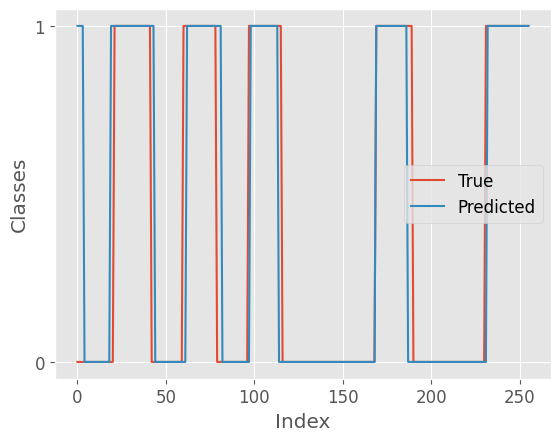

In [64]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(supervised_classes, label="True")
    ax.plot(predicted_states, label="Predicted")
    ax.legend(loc="best")
    ax.set_ylabel("Classes")
    ax.set_xlabel("Index")
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(supervised_classes.unique()))
    ax.yaxis.set_major_formatter(
        mpl.ticker.FixedFormatter(
            [str(elem.item()) for elem in supervised_classes.unique()]
        )
    )
    plt.show()

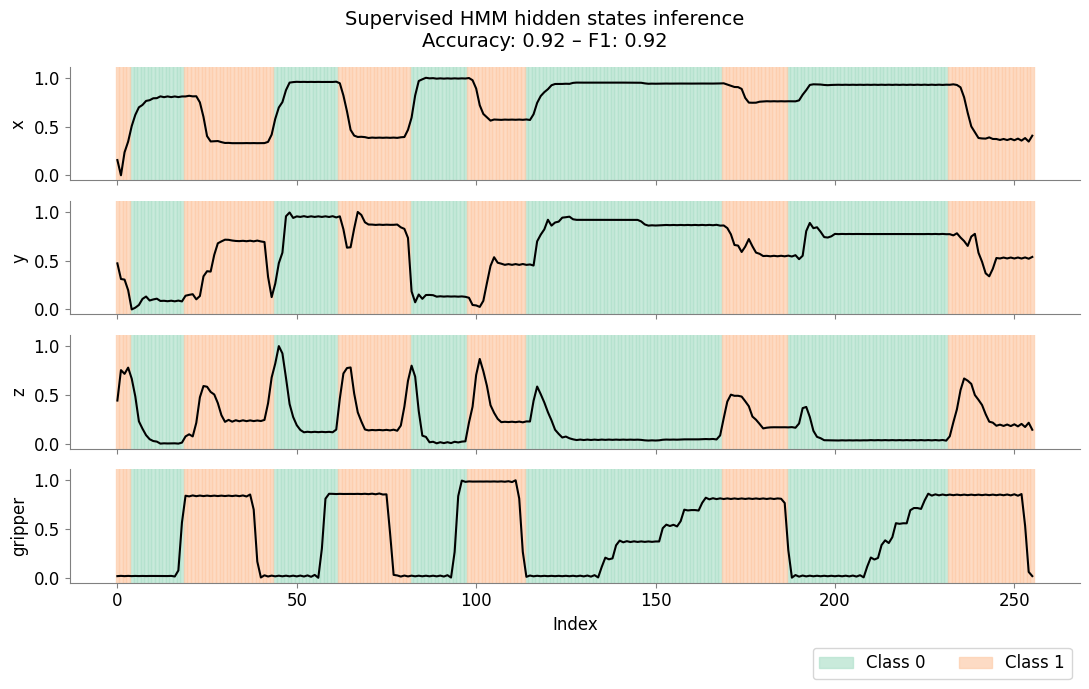

In [65]:
fig, axes = plt.subplots(
    nrows=supervised_observations.shape[1], ncols=1, sharex=True, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
labels = list(traj.drop(columns=["timestamp"]).keys())
ts = torch.arange(end=supervised_observations.shape[0])
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(supervised_observations[:, idx], "k")  # , color=cmap[0])
    ax.set_ylabel(labels[idx])
    ax.spines[["right", "top"]].set_visible(False)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    # fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    # fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    #     ax.fill_between(
    #         x=xs,
    #         y1=fill_min - 1,
    #         y2=fill_max + 1,
    #         color=cmap[sect_i],
    #         alpha=0.5,
    #         transform=ax.get_xaxis_transform(),
    #         label=sect_key,
    #     )
    y_low, y_high = ax.get_ylim()
    y_mid = torch.tensor([y_low, y_high]).mean().item()
    # y_height = 0.05 * (y_high - y_low)
    y_height = y_high - y_low
    for jdx, class_id in enumerate(supervised_classes.unique()):
        xs = ts[predicted_states == class_id]
        for zdx, xi in enumerate(xs):
            if zdx == 0:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                    label=f"Class {class_id}",
                )
            else:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                )
    ax.set_ylim(bottom=y_low * 1.01, top=y_height * 1.01)
axes[-1].set_xlabel("Index")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
# if what_segments == "LowerLevel":
#     bbox_to_anchor = (0.61, -0.6)
# elif what_segments == "HigherLevel":
#     bbox_to_anchor = (0.8, -0.6)
#     bbox_to_anchor = (1, -0.5)
axes[-1].legend(
    bbox_to_anchor=(1, -0.5), ncol=len(supervised_classes.unique()), fontsize=12
)
fig.suptitle(
    f"Supervised HMM hidden states inference\nAccuracy: {accuracy:3.2f} – F1: {f1:3.2f}",
    fontsize=14,
)
# fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### Testing

In [66]:
def fit_predict_model(X_train, y_train, X_test):
    # pyro.set_rng_seed(1)
    pyro.clear_param_store()

    supervised_classes = y_train.to(dtype=int)
    supervised_observations = X_train
    supervised_obs_test = X_test

    nuts_kernel = NUTS(
        # supervised_hmm_continuous,
        supervised_hmm_vectorized,
        jit_compile=True,
        ignore_jit_warnings=True,
        # supervised_hsmm_continuous, jit_compile=True, ignore_jit_warnings=True
    )
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc.run(
        classes=supervised_classes,
        observations=supervised_observations,
        num_hidden_states=num_hidden_states,
        num_features=num_features,
    )

    # Get samples
    samples = mcmc.get_samples()

    # Get posterior means
    mean_transition_prob = samples["transition_prob"].mean(dim=0)
    mean_emission_locs = samples["emission_locs"].mean(dim=0)
    mean_emission_scales = samples["emission_scales"].mean(dim=0)

    # Predict
    predicted_states = viterbi_continuous(
        observations=supervised_obs_test,
        transition_prob=mean_transition_prob,
        emission_locs=mean_emission_locs,
        emission_scales=mean_emission_scales,
    )

    return predicted_states

In [67]:
# n_splits = 3
# tscv = TimeSeriesSplit(n_splits=n_splits)
# for idx, (train_index, test_index) in enumerate(tscv.split(X_down_scaled)):
#     print(f"----- Split {idx + 1}/{n_splits} -----")
#     X_train = X_down_scaled[train_index]
#     X_test = X_down_scaled[test_index]
#     y_train = y_down[train_index]
#     y_test = y_down[test_index]

#     y_pred = fit_predict_model(X_train=X_train, y_train=y_train, X_test=X_test)

#     # Metrics
#     f1 = f1_score(y_test, y_pred, average="macro")
#     print(f"F1: {f1:.2f}")
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"Accuracy: {accuracy:.2f}")
#     # logloss_metric = log_loss(y_true=y_test, y_pred=y_pred, labels=np.arange(len(labels)))
#     # print(f"Log Loss for 'multi:softprob': {logloss_metric}")#:.4f}")

In [68]:
bagfiles = get_bagfiles_from_json(ground_truth_segm_file=ground_truth_segm_file)
bagfiles

[PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [69]:
# bagfile_test = np.random.choice(bagfiles)
# bagfile_test

In [70]:
bagfile_test = bagfiles[filenum]
bagfile_test

PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag')

In [71]:
bagfiles_train = bagfiles
bagfiles_train.remove(bagfile_test)
bagfiles_train

[PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag'),
 PosixPath('/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag')]

In [72]:
# bagfiles_train = [bagfiles[2]]
# bagfile_test = bagfiles[3]

In [73]:
def preprocess_data(traj, what_segments, bagfile, resample_num):
    gt_segm_dict = get_ground_truth_segmentation(
        ground_truth_segm_file=ground_truth_segm_file, bagfile=bagfile
    )
    # traj, gt_segm_dict = filter_fork_spoon(gt_segm_dict=gt_segm_dict, traj=traj)
    # gt_segm_dict = simplify2pickNplace(gt_segm_dict=gt_segm_dict)
    X = traj.drop(columns=["timestamp"])
    y = create_supervised_labels(
        what_segments=what_segments, gt_segm_dict=gt_segm_dict, traj=traj
    )
    idx2filter = np.where(~np.isnan(y))
    assert X.shape[0] == y.shape[0], (
        "`X` and `y` don't have the same number of elements on dimension 0"
    )
    if idx2filter[0].size == 0:
        y_filtered = y
        X_filtered = X
    else:
        y_filtered = y[idx2filter]
        X_filtered = X.iloc[idx2filter]
    X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_filtered)
    # X_down = signal.decimate(x=X_filtered, q=downsampling_factor, axis=0)
    X_down = signal.resample(x=X_filtered, num=resample_num, axis=0)
    minmaxscaler = MinMaxScaler(feature_range=(0, 1))
    X_down_scaled = minmaxscaler.fit_transform(X_down)
    # y_down = np.round(signal.decimate(x=y_filtered, q=downsampling_factor, axis=0)).astype(
    #     int
    # )
    y_down = np.round(signal.resample(x=y_filtered, num=resample_num, axis=0)).astype(
        int
    )
    return torch.tensor(X_down_scaled), torch.tensor(y_down)

In [74]:
for idx, bagfile in enumerate(bagfiles_train):
    print(f"----- Processing file {idx + 1}/{len(bagfiles_train)} -----")
    tmp_traj = extract_eef_data_from_rosbag(bagfile)
    X_down_scaled, y_down = preprocess_data(
        traj=tmp_traj,
        what_segments=what_segments,
        bagfile=bagfile,
        resample_num=resample_num,
    )
    if idx == 0:
        X_train = X_down_scaled.unsqueeze(dim=0)
        y_train = y_down.unsqueeze(dim=0)
    else:
        X_train = torch.concat(
            (X_train.detach().clone(), X_down_scaled.unsqueeze(dim=0)),
            dim=0,
        )
        y_train = torch.concat(
            (y_train.detach().clone(), y_down.unsqueeze(dim=0)), dim=0
        )
X_train.shape, y_train.shape

----- Processing file 1/3 -----
Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-35-57_2025-09-08-16-35-57.bag`


  0%|          | 0/165202 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓
----- Processing file 2/3 -----
Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-43-25_2025-09-08-19-43-25.bag`


  0%|          | 0/191521 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓
----- Processing file 3/3 -----
Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_19-46-18_2025-09-08-19-46-19.bag`


  0%|          | 0/183488 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


(torch.Size([3, 256, 4]), torch.Size([3, 256]))

In [75]:
traj_test = extract_eef_data_from_rosbag(bagfile_test)
X_test, y_test = preprocess_data(
    traj=traj_test,
    what_segments=what_segments,
    bagfile=bagfile_test,
    resample_num=resample_num,
)
X_test.shape, y_test.shape

Extracting TF & gripper data from Bag file: `/home/kir0ul/Projects/table-task-ur5e/rosbag2_2025-09-08_16-33-22_2025-09-08-16-33-23.bag`


  0%|          | 0/186839 [00:00<?, ?it/s]

Extracting TF & gripper data from Bag file: done ✓


(torch.Size([256, 4]), torch.Size([256]))

In [76]:
# Train
y_pred = fit_predict_model(X_train=X_train, y_train=y_train, X_test=X_test)

# Metrics
f1 = f1_score(y_test.flatten(), y_pred.flatten(), average="macro")
print(f"F1: {f1:.2f}")
accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
print(f"Accuracy: {accuracy:.2f}")

Sample: 100%|██████████████████████████| 200/200 [00:19, 10.46it/s, step size=7.04e-02, acc. prob=0.913]


F1: 0.88
Accuracy: 0.88


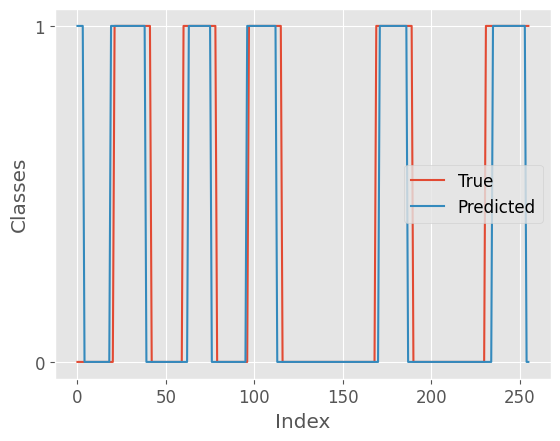

In [77]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()  # figsize=(11, 7))
    ax.plot(y_test, label="True")
    ax.plot(y_pred, label="Predicted")
    ax.legend(loc="best")
    ax.set_ylabel("Classes")
    ax.set_xlabel("Index")
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(supervised_classes.unique()))
    ax.yaxis.set_major_formatter(
        mpl.ticker.FixedFormatter(
            [str(elem.item()) for elem in supervised_classes.unique()]
        )
    )
    plt.show()

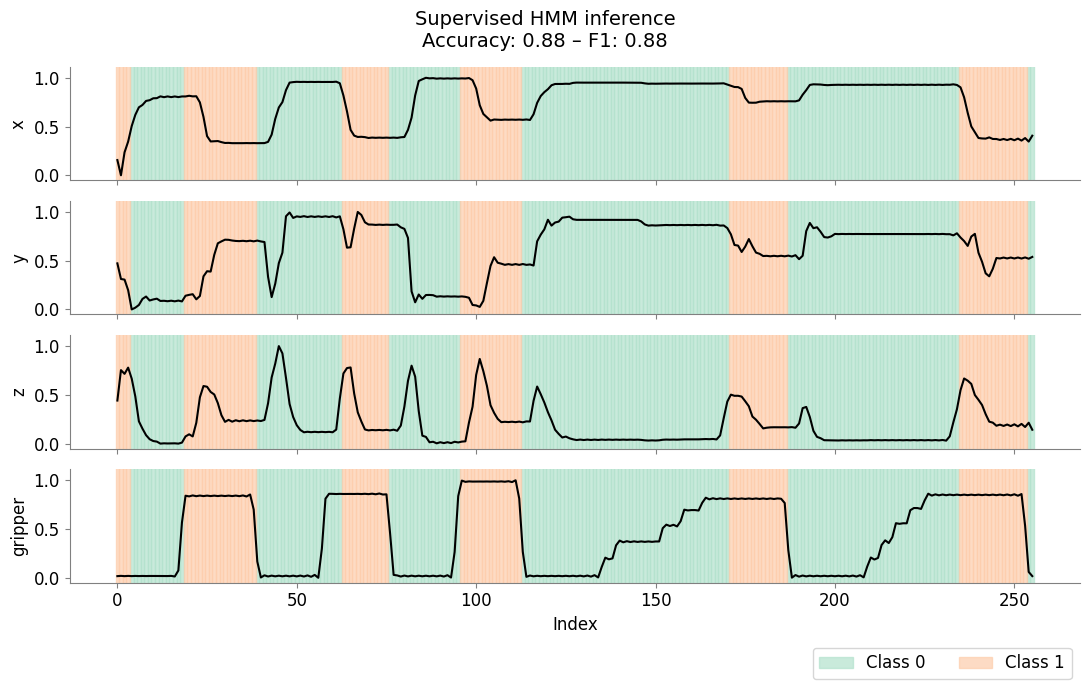

In [78]:
fig, axes = plt.subplots(
    nrows=supervised_observations.shape[1], ncols=1, sharex=True, figsize=(11, 7)
)
cmap = mpl.colormaps.get("Pastel2").colors
labels = list(traj.drop(columns=["timestamp"]).keys())
ts = torch.arange(end=supervised_observations.shape[0])
for idx, ax in enumerate(axes):
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    ax.plot(X_test[:, idx], "k")  # , color=cmap[0])
    ax.set_ylabel(labels[idx])
    ax.spines[["right", "top"]].set_visible(False)
    ax.tick_params(color="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    # fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min(), traj.gripper.min()])
    # fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max(), traj.gripper.max()])
    #     ax.fill_between(
    #         x=xs,
    #         y1=fill_min - 1,
    #         y2=fill_max + 1,
    #         color=cmap[sect_i],
    #         alpha=0.5,
    #         transform=ax.get_xaxis_transform(),
    #         label=sect_key,
    #     )
    y_low, y_high = ax.get_ylim()
    y_mid = torch.tensor([y_low, y_high]).mean().item()
    # y_height = 0.05 * (y_high - y_low)
    y_height = y_high - y_low
    for jdx, class_id in enumerate(supervised_classes.unique()):
        xs = ts[y_pred == class_id]
        for zdx, xi in enumerate(xs):
            if zdx == 0:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                    label=f"Class {class_id}",
                )
            else:
                ax.fill_between(
                    # [x - 1, x],
                    [xi - 0.5, xi + 0.5],
                    [y_mid - y_height] * 2,
                    [y_mid + y_height] * 2,
                    alpha=0.7,
                    color=cmap[jdx],
                )
    ax.set_ylim(bottom=y_low * 1.01, top=y_height * 1.01)
axes[-1].set_xlabel("Index")
# axes[0].legend(bbox_to_anchor=(1.0, 1.02))
# if what_segments == "LowerLevel":
#     bbox_to_anchor = (0.61, -0.6)
# elif what_segments == "HigherLevel":
#     bbox_to_anchor = (0.8, -0.6)
#     bbox_to_anchor = (1, -0.5)
axes[-1].legend(
    bbox_to_anchor=(1, -0.5), ncol=len(supervised_classes.unique()), fontsize=12
)
fig.suptitle(
    f"Supervised HMM inference\nAccuracy: {accuracy:3.2f} – F1: {f1:3.2f}", fontsize=14
)
# fig.autofmt_xdate()
fig.tight_layout()
plt.show()